In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [3]:
!pip install PyMuPDF

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, BatchNormalization, Multiply, Add

# Attention Block
def attention_gate(x, g, inter_channels):
    """
    x: Skip connection from encoder
    g: Decoder features
    inter_channels: Intermediate channel size for attention computation
    """
    theta_x = Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(x)  # Transform encoder features
    phi_g = Conv2D(inter_channels, (1,1), strides=(1,1), padding='same')(g)  # Transform decoder features

    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    psi = Conv2D(1, (1,1), strides=(1,1), padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)  # Generate attention map

    x = Multiply()([x, psi])  # Apply attention to skip connection
    return x

# U-Net with Attention
def attention_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    att5 = attention_gate(c3, u5, 256)  # Apply attention to skip connection
    u5 = Concatenate()([u5, att5])

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    att6 = attention_gate(c2, u6, 128)
    u6 = Concatenate()([u6, att6])

    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    att7 = attention_gate(c1, u7, 64)
    u7 = Concatenate()([u7, att7])

    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c7)  # Binary segmentation

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = attention_unet(input_shape=(512, 512, 3))
model.load_weights('model_weights.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 512)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 256)  │         65,792 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 256)  │        131,328 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 256)  │              0 │ conv2d_8[0][0],        │
│                           │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 256)  │              0 │ add[0][0]              │
├──────────────────────

 Total params: 8,042,308 (30.68 MB)

 Trainable params: 8,042,308 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import os
from skimage.graph import route_through_array
from heapq import heappush, heappop

def heuristic(a, b):
    """Calculate the squared distance between two points."""
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    """Perform A* algorithm to find a path from start to goal in a binary array."""
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))

    while oheap:
        current = heappop(oheap)[1]

        if current == goal:
        # if np.linalg.norm(np.array(current) - np.array(goal)) < 3:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        neighbors = sorted(neighbors, key=lambda x: abs((current[0] + x[0]) - goal[0]) + abs((current[1] + x[1]) - goal[1]))  #Reduces zigzag paths, improving efficiency
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            # tentative_g_score = gscore[current] + np.linalg.norm(np.array(current) - np.array(neighbor))
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
            # if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, float('inf')):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                # fscore[neighbor] = tentative_g_score + np.linalg.norm(np.array(neighbor) - np.array(goal))
                heappush(oheap, (fscore[neighbor], neighbor))

    return []

In [7]:
from scipy.signal import find_peaks

In [8]:
def preprocess_image(image_path,target_size):
    """Read and convert an image to grayscale."""
    try:
        img = imread(image_path)
        if target_size is not None:
            img = img[target_size[0]:target_size[1], target_size[2]:target_size[3],:]
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
        if img.ndim > 2:
            img = rgb2gray(img)
        return img
    except FileNotFoundError:
        print(f"Error: File {image_path} not found.")
        return None

def binarize_image(image):
    """Binarize an image using Otsu's threshold."""
    threshold = threshold_otsu(image)
    return image < threshold

def horizontal_projections(sobel_image):
    """Calculate horizontal projections of the binary image."""
    return np.sum(sobel_image, axis=1)

def find_peak_regions(hpp, threshold):
    """Identify peak regions based on the horizontal projection profile."""
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append(i)
    # peaks, _ = find_peaks(hpp, height=threshold, distance=10, prominence=5) #Improving peak finding
    return peaks

def line_segmentation(image_path, segmented_image_path, segmented_image_folder, threshold=None, min_peak_group_size = 10,target_size=None,ct=0, parent_line_num=None,recursive=False):
    """Segment an image into lines using horizontal projections and A*."""
    img = preprocess_image(image_path,target_size)
    if img is None:
        return

    binarized_image = binarize_image(img)

    # binarized_image = binarized_image.astype(np.uint8) * 255
    # #Added morphological operations for better segmentation
    # kernel = np.ones((3, 3), np.uint8)
    # binarized_image = cv2.dilate(binarized_image, kernel, iterations=1)
    # binarized_image = cv2.erode(binarized_image, kernel, iterations=1)
    # binarized_image = binarized_image > 127


    hpp = horizontal_projections(binarized_image)

    if threshold == None:
      threshold = (np.max(hpp)-np.min(hpp))/2

    peaks = find_peak_regions(hpp, threshold)

    peaks_indexes = np.array(peaks).astype(int)

    segmented_img = np.copy(img)
    r, c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_indexes:
            segmented_img[ri, :] = 0

    diff_between_consec_numbers = np.diff(peaks_indexes)
    indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
    peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
    peak_groups = [item for item in peak_groups if len(item) > min_peak_group_size]

    binary_image = binarize_image(img)
    segment_separating_lines = []

    for sub_image_index in peak_groups:
        start_row = sub_image_index[0]
        end_row = sub_image_index[-1]

        start_row = max(0, start_row)
        end_row = min(binary_image.shape[0], end_row)

        nmap = binary_image[start_row:end_row, :]

        start_point = (int(nmap.shape[0] / 2), 0)
        end_point = (int(nmap.shape[0] / 2), nmap.shape[1] - 1)

        path, _ = route_through_array(nmap, start_point, end_point)

        path = np.array(path) + start_row

        segment_separating_lines.append(path)

    seperated_images = []

    for index, line_segments in enumerate(segment_separating_lines):
        if index < len(segment_separating_lines) - 1:
            # lower_line = np.min(segment_separating_lines[index][:, 0])
            # upper_line = np.max(segment_separating_lines[index + 1][:, 0])
            lower_line = int(np.median(segment_separating_lines[index][:,0]))      # median (better segmentation obsereved)
            upper_line = int(np.median(segment_separating_lines[index+1][:,0]))
            seperated_images = [img for img in seperated_images if img.shape[0] > 20] #Prevents saving very small fragments as separate lines.
            seperated_images.append(img[lower_line:upper_line])

    if not os.path.exists(segmented_image_folder):
        os.makedirs(segmented_image_folder)

    # Initialize count
    count = ct

    image_heights = [line_image.shape[0] for line_image in seperated_images]
    if not image_heights:  # Check if empty
        print(f"Warning: No segmented lines found in {image_path}. Skipping.")
        return
    height_threshold = np.percentile(image_heights, 90)

    len_seperated_images = len(seperated_images)

    for index, line_image in enumerate(seperated_images):
        if parent_line_num is None:
            output_path = os.path.join(segmented_image_folder, f'{os.path.basename(segmented_image_path)}_line_{count + 1}.png')
        else:
            output_path = os.path.join(segmented_image_folder, f'{os.path.splitext(os.path.basename(segmented_image_path))[0]}_{count + 1}.png')
            if index < len(seperated_images) - 1:
              continue

        plt.imsave(output_path, line_image, cmap='gray')
        count += 1
        print(f"Saved line image to {output_path}")

        if line_image.shape[0] > height_threshold and not recursive:
            line_segmentation(output_path,output_path, segmented_image_folder,min_peak_group_size = 3 ,parent_line_num=f"{parent_line_num}_{count}" if parent_line_num else count,recursive=True)
            os.remove(output_path)
            print(f"Deleted line image {output_path}")
        elif recursive:
            return

In [9]:
!pip install deskew

In [10]:
import math
from typing import Tuple, Union

import cv2
import numpy as np

from deskew import determine_skew


def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [11]:
%pip install pdf2image
import pdf2image
def pdf_to_images(pdf_path, output_folder):
    """Convert PDF pages to images and save them in the output folder."""
    pages_folder = os.path.join(output_folder, "pages")
    if not os.path.exists(pages_folder):
        os.makedirs(pages_folder)

    images = pdf2image.convert_from_path(pdf_path, dpi=300)
    image_paths = []
    print(f"📄 Found {len(images)} pages in {pdf_path}")
    for i, image in enumerate(images):
        image_path = os.path.join(pages_folder, f"{os.path.basename(pdf_path).replace('.pdf', '')}_page_{i+1}.png")
        image.save(image_path, "PNG")
        image_paths.append(image_path)
        print(f"✅ Saved: {image_path}")

    print(f"📂 All {len(image_paths)} pages saved in {pages_folder}")
    return image_paths



In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocessImage(image_path,folder_path):
  """
  Preprocesses an image by applying various image processing steps such as denoising, thresholding,
  and removal of horizontal and vertical lines, and saves the final processed image.

  Args:
  - image_path (str): The file path to the input image to be processed.
  - folder_path (str): The directory where the final processed image will be saved.

  Returns:
  - str: The path of the final processed image.
  """
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)
  # Read the image
  image = cv2.imread(image_path)

  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply denoising
  gray = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

  # Apply binary thresholding using Otsu's method
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Copy the original image to preserve it
  removed = image.copy()

  # Remove vertical lines
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
  remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
  cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      cv2.drawContours(removed, [c], -1, (255, 255, 255), 4)

  # Remove horizontal lines
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
  remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
  cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      cv2.drawContours(removed, [c], -1, (255, 255, 255), 5)

  # Repair kernel
  repair_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  removed = 255 - removed
  dilate = cv2.dilate(removed, repair_kernel, iterations=5)
  dilate = cv2.cvtColor(dilate, cv2.COLOR_BGR2GRAY)
  pre_result = cv2.bitwise_and(dilate, thresh)

  # Final result
  result = cv2.morphologyEx(pre_result, cv2.MORPH_CLOSE, repair_kernel, iterations=5)
  final = cv2.bitwise_and(result, thresh)

  # Invert the final image
  invert_final = 255 - final

  # Plotting each step
  fig, axes = plt.subplots(4, 2, figsize=(15, 20))
  axes = axes.flatten()

  axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(thresh, cmap='gray')
  axes[1].set_title('Threshold Image')
  axes[1].axis('off')

  axes[2].imshow(255 - remove_vertical, cmap='gray')
  axes[2].set_title('Vertical Lines Removed')
  axes[2].axis('off')

  axes[3].imshow(255 - remove_horizontal, cmap='gray')
  axes[3].set_title('Horizontal Lines Removed')
  axes[3].axis('off')

  axes[4].imshow(cv2.cvtColor(removed, cv2.COLOR_BGR2RGB))
  axes[4].set_title('Removed Image')
  axes[4].axis('off')

  axes[5].imshow(dilate, cmap='gray')
  axes[5].set_title('Dilated Image')
  axes[5].axis('off')

  axes[6].imshow(pre_result, cmap='gray')
  axes[6].set_title('Pre Result')
  axes[6].axis('off')

  axes[7].imshow(invert_final, cmap='gray')
  axes[7].set_title('Inverted Final')
  axes[7].axis('off')

  plt.tight_layout()
  plt.show()

  processed_image_path = os.path.join(folder_path, f"{os.path.splitext(os.path.basename(image_path))[0]}-preprocessed.png")
  # Save the final image
  cv2.imwrite(processed_image_path, invert_final)
  return processed_image_path

In [13]:
import cv2
import numpy as np

# def get_middle_text_contour(contours, ori_width, ori_height, center_threshold=0.3):
#     """
#     Filters and selects the contour that corresponds to the middle text.

#     Args:
#     - contours: List of detected contours.
#     - ori_width: Original image width.
#     - ori_height: Original image height.
#     - center_threshold: Proportion of image width considered the middle.

#     Returns:
#     - (x_min, y_min, x_max, y_max): Bounding box of the selected region.
#     """
#     center_x = ori_width // 2
#     center_range = (ori_width * center_threshold) // 2  # Define a central strip

#     best_contour = None
#     max_area = 0
#     x_min, y_min, x_max, y_max = ori_width, ori_height, 0, 0

#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         contour_center_x = x + w // 2

#         # Check if the contour is within the central region
#         if abs(contour_center_x - center_x) < center_range:
#             area = w * h
#             if area > max_area:
#                 best_contour = contour
#                 max_area = area
#                 x_min, y_min, x_max, y_max = x, y, x + w, y + h

#     return x_min, y_min, x_max, y_max

def get_middle_text_contour(binary_image):
    """Find the largest text region in the binary image instead of just the middle portion."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area to get the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if not contours:
        return None  # No text found

    # Get bounding box around the largest contour (largest text region)
    x, y, w, h = cv2.boundingRect(contours[0])

    # Expand the box slightly to include nearby text
    expansion = 10  # Adjust this to fine-tune text capture
    y = max(0, y - expansion)
    h = min(binary_image.shape[0] - y, h + 2 * expansion)

    return x, y, w, h  # Return the bounding box for text


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_segment_and_crop_image(model, img_path, preprocess_image_path, output_folder, padding=10, min_contour_area=100):
    """
    Processes an image for segmentation using a U-Net model and crops the original image based on the largest contour.

    Args:
    - model (tf.keras.Model): Trained U-Net model for image segmentation.
    - img_path (str): Path to the original image.
    - preprocess_image_path (str): Path to the preprocessed image.
    - output_folder (str): Folder to save the cropped image.
    - padding (int): Padding around the detected region.
    - min_contour_area (int): Minimum contour area to be considered for cropping.

    Returns:
    - str: The path of the cropped image.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Read the original image in grayscale
    img = cv2.imread(preprocess_image_path, 0)

    # Apply thresholding to create a binary image
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

    # Resize the image to the model input size (512x512)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Expand dimensions to match model input
    # img = np.expand_dims(img, axis=-1)
    # img_np = np.expand_dims(img, axis=0)
    img_np = np.expand_dims(img, axis=0).astype(np.float32) / 255.0  # Shape: (1, 512, 512, 3)
    # Predict the segmentation mask using the U-Net model
    pred = model.predict(img_np)
    pred = np.squeeze(pred, axis=0)  # Remove batch dimension (512, 512, 1)
    pred = np.squeeze(pred, axis=-1)  # Remove channel dimension (512, 512)

    # Display the segmentation result
    plt.imshow(pred, cmap='gray')
    plt.title('U-Net Segmentation')
    plt.axis('off')
    plt.show()

    # Read the original image
    original_img = cv2.imread(preprocess_image_path)

    # Get original dimensions
    ori_height, ori_width = original_img.shape[:2]

    # Resize the mask to match the original image dimensions
    resized_mask = cv2.resize(pred, (ori_width, ori_height))

    # Convert the resized mask to 8-bit unsigned integer type
    resized_mask = (resized_mask * 255).astype(np.uint8)

    # Apply Otsu's threshold to get a binary image
    _, binary_mask = cv2.threshold(resized_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise and connect nearby text
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small noise
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    if not valid_contours:
        print("No valid text regions found.")
        return None

    Find the bounding rectangle that encompasses all valid contours
    x_min, y_min = ori_width, ori_height
    x_max, y_max = 0, 0

    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    # x_min, y_min, x_max, y_max = get_middle_text_contour(valid_contours, ori_width, ori_height)

    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(ori_width, x_max + padding)
    y_max = min(ori_height, y_max + padding)

    # Crop the original image
    cropped_img = original_img[y_min:y_max, x_min:x_max]

    # Create output path
    output_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(img_path))[0]}-cropped.png")

    # Save the cropped image
    cv2.imwrite(output_path, cropped_img)

    return output_path

In [15]:

import math
from typing import Tuple, Union
import cv2
import numpy as np
from deskew import determine_skew
import matplotlib.pyplot as plt

def postProcessImage(image_path, cropped_image_path,output_folder):
    """
    Post-processes an image by deskewing, sharpening, and applying morphological dilation, then saves the final processed image.

    Args:
    - image_path (str): Path to the original image.
    - cropped_image_path (str): Path to the cropped image to be post-processed.
    - output_folder (str): Directory where the final post-processed image will be saved.

    Returns:
    - str: The path of the final post-processed image.
    """
    # Load the image
    image = cv2.imread(cropped_image_path)

    # Deskew Image
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, (0, 0, 0))
    # rotated = grayscale

    # Sharpening (reduced intensity)
    blurred = cv2.GaussianBlur(rotated, (1,1), sigmaX=3, sigmaY=3)
    sharpened = cv2.addWeighted(rotated, 1.5, blurred, -0.5, 0)

    # Morphological dilation to thicken the text
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    dilated = cv2.dilate(sharpened, dilate_kernel, iterations=1)

    output_path = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(image_path))[0]}-postprocessed.png")
    cv2.imwrite(output_path, sharpened)

    return output_path

In [27]:
def process_pdf_folder(pdf_folder, segmented_images_folder,pre_process_folder,crop_folder):
    """Process all PDFs in a folder, convert them to images, and segment lines."""
    if not os.path.exists(segmented_images_folder):
        os.makedirs(segmented_images_folder)

    for pdf_file in os.listdir(pdf_folder):
        if pdf_file.endswith(".pdf"):
            pdf_path = os.path.join(pdf_folder, pdf_file)
            pdf_name = pdf_file.replace(".pdf", "")

            output_folder = os.path.join(segmented_images_folder, pdf_name)
            pdf_images_folder = os.path.join(output_folder, "images")  # Store original extracted images
            segmented_images_folder = os.path.join(output_folder, "segmented")
            # if not os.path.exists(segmented_images_folder):
            #     os.makedirs(segmented_images_folder)

            os.makedirs(pdf_images_folder, exist_ok=True)
            os.makedirs(segmented_images_folder, exist_ok=True)

            image_paths = pdf_to_images(pdf_path, output_folder)
            for img_path in image_paths:
                preprocess_image_path = preprocessImage(img_path,pre_process_folder)
                cropped_image_path = process_segment_and_crop_image(model,img_path, preprocess_image_path,crop_folder)
                post_process_image_path = postProcessImage(img_path,cropped_image_path,crop_folder)
                line_segmentation(post_process_image_path, post_process_image_path, segmented_images_folder)

                # Get sorted image paths
                segmented_image_paths = get_segmented_image_paths(img_path, segmentation_folder)
                sorted_image_paths = sort_segmented_image_paths(segmented_image_paths)

                # Read images from directory and store them in a list
                seperated_images = []
                for image_path in sorted_image_paths:
                  image = cv2.imread(image_path)
                  if image is not None:
                    seperated_images.append(image)
                if len(seperated_images) == 0:
                  print("No images found after segmentation. Skipping plot.")
                  # return  # Exit the function to prevent errors
                  continue
                # Create a subplot for each image and display them
                fig, ax = plt.subplots(figsize=(5, 5), nrows=len(seperated_images))

                for index, line_image in enumerate(seperated_images):
                  print(f"{sorted_image_paths[index]}: {line_image.shape}")
                  ax[index].imshow(line_image, cmap="gray")
                  ax[index].axis('off')  # Hide axes

                plt.axis('off')
                plt.show()

                print("*****************************************************************")


In [17]:
import os
import re
import matplotlib.pyplot as plt
import cv2

def get_segmented_image_paths(input_path, segmented_image_dir):
    # Get the base name from the input path
    base_name = os.path.basename(input_path)

    # List all files in the directory
    files = os.listdir(segmented_image_dir)

    # Filter the files to get only those that start with the base name and end with "_line_*.png"
    segmented_files = [os.path.join(segmented_image_dir, f) for f in files if f.startswith(base_name) and "_line_" in f and f.endswith(".png")]

    return segmented_files

def extract_line_number(file_path):
    # Extract the line number(s) from the file name using regex
    match = re.search(r'_line_(\d+(_\d+)?).png$', file_path)
    if match:
        return list(map(int, match.group(1).split('_')))
    return [-1]

def sort_segmented_image_paths(image_paths):
    # Sort the list of paths based on the extracted line number
    sorted_paths = sorted(image_paths, key=extract_line_number)
    return sorted_paths

In [18]:
%pip install fitz

In [19]:
%pip install tools

In [20]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


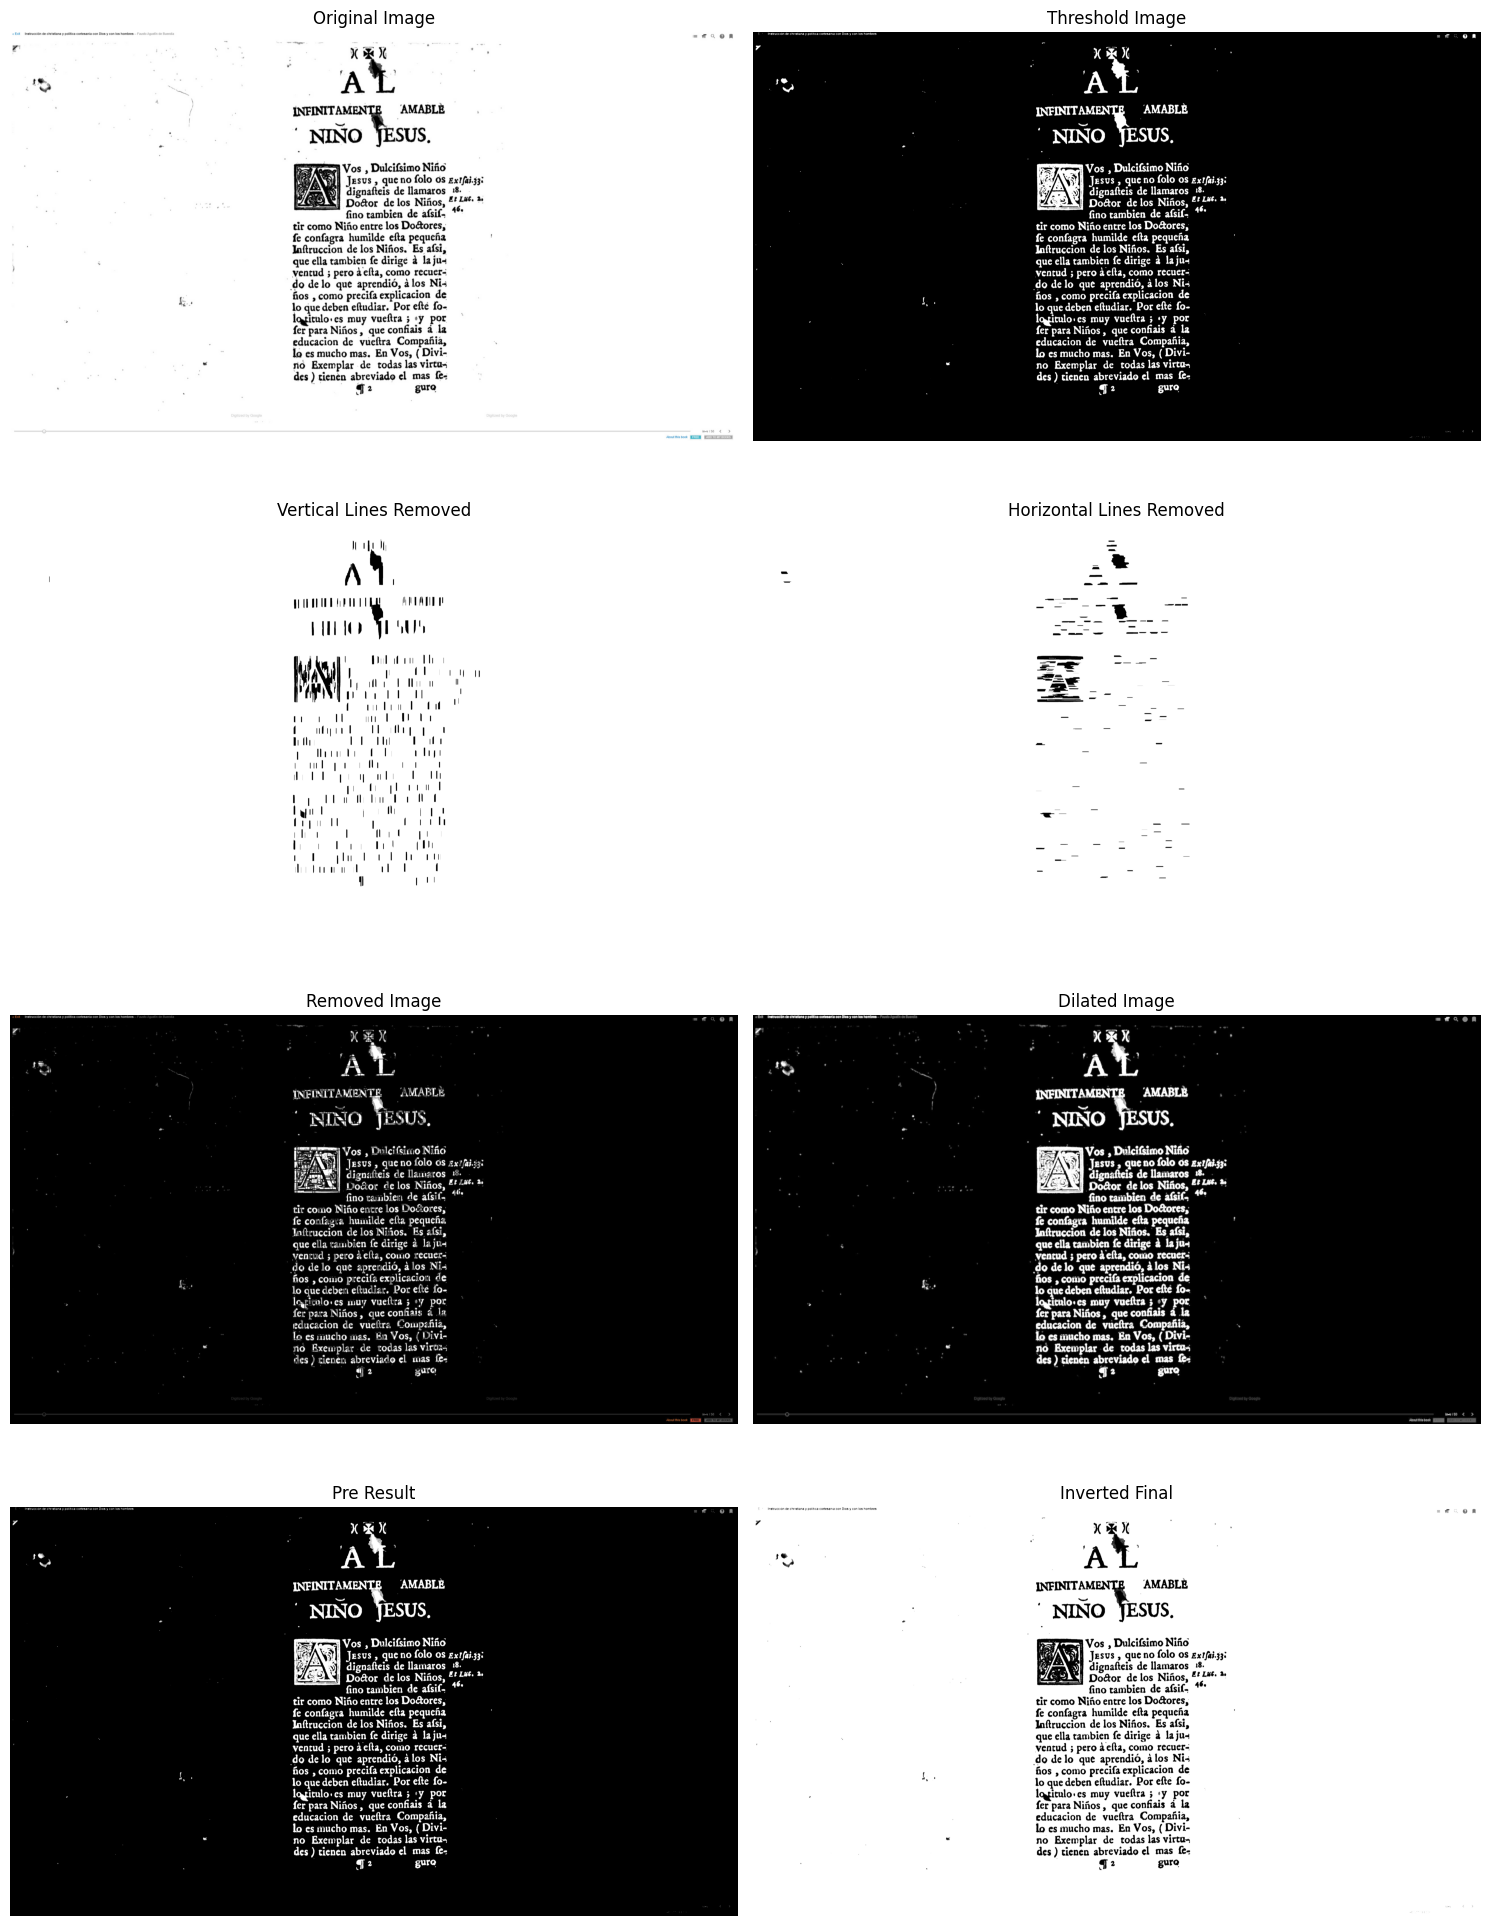

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


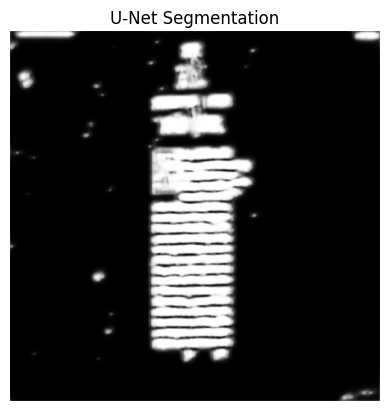

Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_1.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_1_1.png
Deleted line image test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_1.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_2.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_3.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_4.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocessed.png_line_5.png
Saved line image to test2/segemented/Buendia - Instruccion/segmented/Buendia - Instruccion_page_1-postprocesse

In [25]:
# segmented_images_folder = ""


pre_process_folder = 'test2/preprocess'
crop_folder = 'test2/cropped'
segmentation_folder = 'test2/segemented'


process_pdf_folder('Pdfs',segmentation_folder,pre_process_folder,crop_folder)